In [2]:
from sklearn.ensemble import GradientBoostingClassifier

In [3]:
dt = pandas.read_csv("jets.csv", sep=" ", header=None, names=[
    "ev", "nj", "pt", "eta", "id", "csv_ivf", "csv", "csv_sl", "cl", "nsv", "sv_pt", "sv_eta", "sv_ntrk", "sv_mass", "chi" 
])

dt = dt[(dt["csv"]>0) & (dt["csv_ivf"]>0) & (dt["csv"]<1) & (dt["csv_ivf"]<1)]
dt["abs_eta"] = abs(dt["eta"])

In [4]:
def flatten(x, y, n):
    x = numpy.array(x)
    xs = sorted(x)
    edges_x = numpy.zeros(n + 1)
    for i in range(n):
        edges_x[i] = xs[i* len(x)/n]
    edges_x[-1] = xs[-1]

    y = numpy.array(y)
    ys = sorted(y)
    edges_y = numpy.zeros(n + 1)
    for i in range(n):
        edges_y[i] = ys[i* len(y)/n]
    edges_y[-1] = ys[-1]

    ret = numpy.zeros((n, n))
    for i in range(len(x)):
        bx = numpy.searchsorted(edges_x, x[i])-1
        by = numpy.searchsorted(edges_y, y[i])-1
        if bx<0:
            bx=0
        if by<0:
            by=0
        ret[bx, by] += 1
    return ret, edges_x, edges_y

In [5]:
def copula_test(x1, x2, nbins):
    h = flatten(x1, x2, nbins)
    e = len(x1) / float(nbins**2)
    hi = (h[0] - e)/numpy.sqrt(e)
    chi2 = sum(sum(numpy.power(hi, 2))) / float(nbins**2 - (2*nbins-1))
    return (hi, h[1], h[2]), chi2

def copula_test_chi2(x, y):
    nbins = int(numpy.sqrt(len(x) / 30))+1
    (hh, bx, by), chi2 = copula_test(x, y, nbins)
    return scipy.stats.chi2(1).pdf(chi2)

In [6]:
def draw_distribution(label, bins=numpy.linspace(0, 1, 100)):
    hist_b, hist_edges = numpy.histogram(dt[dt["cl"]==2][label], bins=bins)
    hist_nonb, hist_edges = numpy.histogram(dt[dt["cl"]!=2][label], bins=bins)
    hist_c, hist_edges = numpy.histogram(dt[dt["cl"]==1][label], bins=bins)
    hist_l, hist_edges = numpy.histogram(dt[dt["cl"]==0][label], bins=bins)

    cumprob_b = numpy.cumsum(hist_b)/float(sum(hist_b))
    cumprob_nonb = numpy.cumsum(hist_nonb)/float(sum(hist_nonb))

    hist_b = hist_b / float(sum(hist_b))
    hist_nonb = hist_nonb / float(sum(hist_nonb))
    hist_c = hist_c / float(sum(hist_c))
    
    plt.figure(figsize=(8,8))
    plt.bar(hist_edges[:-1], hist_b, numpy.diff(hist_edges), lw=0, alpha=0.5)
    plt.bar(hist_edges[:-1], hist_nonb, numpy.diff(hist_edges), lw=0, color="red", alpha=0.5)
    plt.bar(hist_edges[:-1], hist_c, numpy.diff(hist_edges), lw=0, color="green", alpha=0.5)
    return hist_edges, cumprob_b, cumprob_nonb

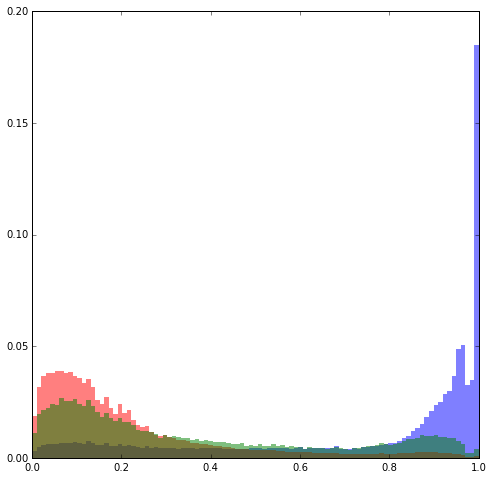

In [7]:
csv = draw_distribution("csv")

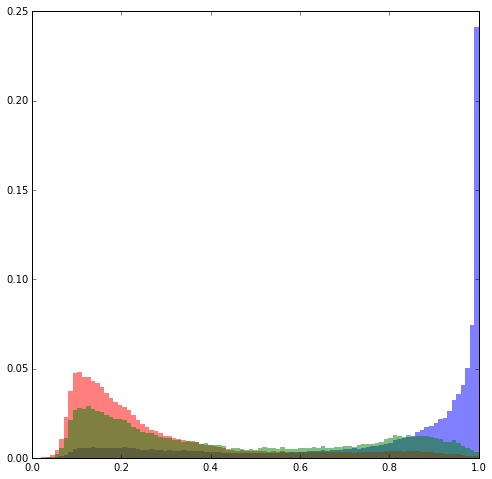

In [8]:
csv_ivf = draw_distribution("csv_ivf")

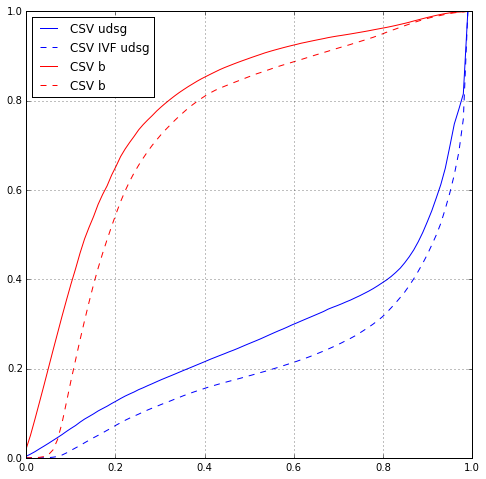

In [9]:
plt.figure(figsize=(8,8))
plt.plot(csv[0][:-1], csv[1], ls="-", label="CSV udsg")
plt.plot(csv[0][:-1], csv_ivf[1], ls="--", color="blue", label="CSV IVF udsg")

plt.plot(csv[0][:-1], csv[2], ls="-", color="red", label="CSV b")
plt.plot(csv[0][:-1], csv_ivf[2], ls="--", color="red", label="CSV b")
plt.legend(loc=2)
plt.grid()

In [10]:
dt["prob_b_csv"] = map(lambda x: csv[1][csv[0][:-2].searchsorted(x)], dt["csv"])
dt["prob_nonb_csv"] = map(lambda x: csv[2][csv[0][:-2].searchsorted(x)], dt["csv"])

dt["prob_b_csv_ivf"] = map(lambda x: csv_ivf[1][csv_ivf[0][:-2].searchsorted(x)], dt["csv_ivf"])
dt["prob_nonb_csv_ivf"] = map(lambda x: csv_ivf[2][csv_ivf[0][:-2].searchsorted(x)], dt["csv_ivf"])

In [11]:
from sklearn.metrics import mutual_info_score

def calc_MI(x, y, bins):
    c_xy = numpy.histogram2d(x, y, bins)[0]
    #c_xx = numpy.histogram2d(x, x, bins)[0]
    mi = mutual_info_score(None, None, contingency=c_xy)
    #mi_norm = mi /  mutual_info_score(None, None, contingency=c_xx)
    return mi

In [12]:
def bootstrap(dt, func):
    x = func(dt)
    xs = []
    for i in range(10):
        rndinds = numpy.random.choice(dt.index, int(len(dt)*0.8))
        if len(rndinds)>10:
            xs.append(func(dt.ix[rndinds]))
        else:
            break
    xe = numpy.std(xs) if len(xs)>4 else x
    return x, xe

In [13]:
def calc_mi_in_bin(dt, v, x1, x2):
    s = dt[(dt[v] > x1) & (dt[v] <= x2)][["csv_ivf", "csv"]]
    x, xe = bootstrap(s, lambda dt: calc_MI(dt["csv_ivf"], dt["csv"], 100))
    return x, xe

def calc_lincorr_in_bin(dt, v, x1, x2):
    s = dt[(dt[v] > x1) & (dt[v] <= x2)][["csv_ivf", "csv"]]
    x, xe = bootstrap(s, lambda dt: numpy.corrcoef(dt["csv_ivf"], dt["csv"])[0,1])
    return x, xe

def calc_bschi2_in_bin(dt, v, x1, x2):
    s = dt[(dt[v] > x1) & (dt[v] <= x2)][["csv_ivf", "csv"]]
    x, xe = bootstrap(s, lambda dt: copula_test_chi2(dt["csv_ivf"], dt["csv"]))
    return x, xe

265.84127717094299

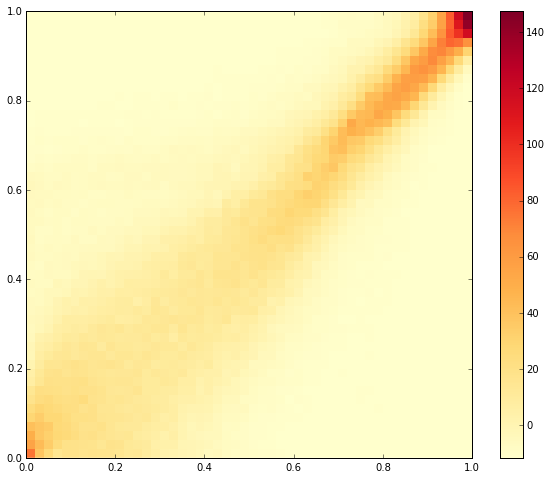

In [16]:
fig = plt.figure(figsize=(10,8))
h = copula_test(dt["csv_ivf"], dt["csv"], 50)
plt.imshow(h[0][0], interpolation="none",
    extent=[min(h[0][1]), max(h[0][1]), min(h[0][2]), max(h[0][2])], origin="lower",
    aspect="auto", cmap=plt.cm.YlOrRd
)
plt.colorbar()
h[1]

In [17]:
from matplotlib.colors import LogNorm

<matplotlib.colorbar.Colorbar instance at 0x1192cc5f0>

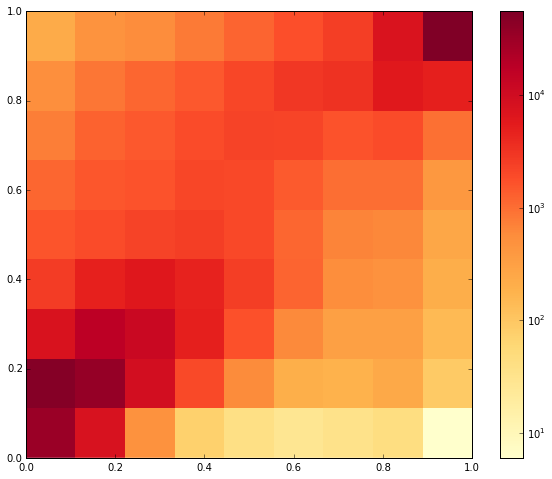

In [18]:
fig = plt.figure(figsize=(10,8))
h = numpy.histogram2d(dt["csv_ivf"], dt["csv"], 9)
hh = h[0]
hh += 1
plt.imshow(h[0], interpolation="none",
    extent=[min(h[1]), max(h[1]), min(h[2]), max(h[2])], origin="lower",
    aspect="auto", norm=LogNorm(vmin=numpy.min(h[0]), vmax=numpy.max(h[0])),
    cmap=plt.cm.YlOrRd
)
plt.colorbar()

In [19]:
def by_class(func, v, bins):
    xs = numpy.zeros((len(bins), 3))
    es = numpy.zeros((len(bins), 3))
    
    
    for i in range(len(bins)-1):
        for cl in [0,1,2]:
            x, e = func(dt[dt["cl"]==cl], v, bins[i], bins[i+1])
            xs[i, cl] = x 
            es[i, cl] = e
    return bins, xs, es

In [20]:
bins, mis, es = by_class(calc_bschi2_in_bin, "pt", numpy.linspace(20, 500, 11))

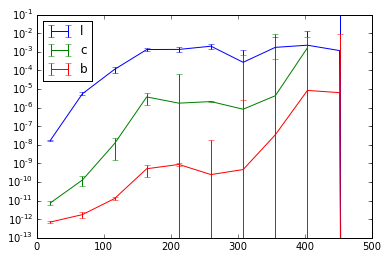

In [21]:
plt.errorbar(bins, mis[:, 0], es[:, 0], label="l")
plt.errorbar(bins, mis[:, 1], es[:, 1], label="c")
plt.errorbar(bins, mis[:, 2], es[:, 2], label="b")
plt.yscale("log")
plt.legend(loc="best")

In [22]:
bins, mis, es = by_class(calc_mi_in_bin, "pt", numpy.linspace(20, 500, 31))

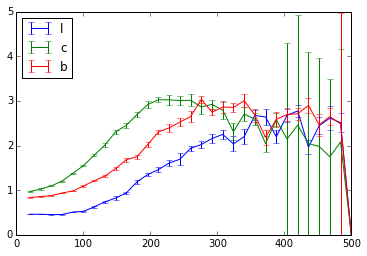

In [23]:
plt.errorbar(bins, mis[:, 0], es[:, 0], label="l")
plt.errorbar(bins, mis[:, 1], es[:, 1], label="c")
plt.errorbar(bins, mis[:, 2], es[:, 2], label="b")
plt.legend(loc="best")

In [24]:
bins, mis, es = by_class(calc_lincorr_in_bin, "pt", numpy.linspace(20, 500, 21))

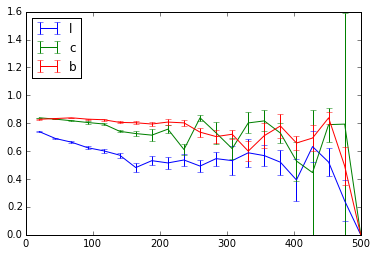

In [25]:
plt.errorbar(bins, mis[:, 0], es[:, 0], label="l")
plt.errorbar(bins, mis[:, 1], es[:, 1], label="c")
plt.errorbar(bins, mis[:, 2], es[:, 2], label="b")
plt.legend(loc="best")

In [26]:
from sklearn.metrics import roc_curve, auc

In [27]:
class Data:
    def __init__(self, dt, vlist, sig, bg=None):
        self.dt = dt
        
        if not bg is None:
            self.train_dt = dt[(dt["cl"] == sig) | (dt["cl"] == bg)]
        else:
            self.train_dt = dt[(dt["cl"] == sig) | (dt["cl"] != sig)]
        
        self.vlist = vlist
        
        self.sig = sig
        self.bg = bg
        
        self.indices = numpy.random.permutation(self.train_dt.index)
        self.train = self.indices[0:len(self.indices)/2]
        self.test = self.indices[len(self.indices)/2:]

        self.X_train = self.train_dt.ix[self.train, vlist]
        self.y_train = self.train_dt.ix[self.train, ["cl"]] == sig
        self.X_test = self.train_dt.ix[self.test, vlist]
        self.y_test = self.train_dt.ix[self.test, ["cl"]] == sig
        
    def fit_classifier(self, **kwargs):
        X_train, y_train = self.X_train, self.y_train
        y_train = numpy.array(y_train).ravel()
        print "training over ", len(X_train), " points"
        classifier = GradientBoostingClassifier(**kwargs)

        classifier.fit(X_train, y_train)
        return classifier

In [28]:
def roc(probas, data):
    fpr, tpr, thresholds = roc_curve(data.y_test, probas[:, 1])
    return fpr, tpr

def probas_comb(classifiers, data, weights):
    probtot = None
    for classifier, w in zip(classifiers, weights):
        probas = classifier.predict_proba(data.X_test)
        if probtot is None:
            probtot = w*probas
        else:
            probtot += w * probas
        
    return probtot

In [29]:
class CombData:
    def __init__(self, dt, vlist):
        self.dc = Data(dt, vlist, 2, 1)
        self.dl = Data(dt, vlist, 2, 0)
    
    def fit_classifier(self, **kwargs):
        self.cls_c = self.dc.fit_classifier(**kwargs)
        self.cls_l = self.dl.fit_classifier(**kwargs)

    def probas(self, w=0.25):
        pc = probas_comb([self.cls_c, self.cls_l], self.dc, [w, 1.0 - w])
        pl = probas_comb([self.cls_c, self.cls_l], self.dl, [w, 1.0 - w])
        return pc, pl
    
    def rocs(self):
        pc, pl = self.probas()
        rc = roc(pc, self.dc)
        rl = roc(pl, self.dl)
        return rc, rl

In [30]:
def get_aucs(cls, data, n=100):
    a_ = []
    for i, pb in enumerate(cls.staged_predict_proba(data.X_test)):
        if i%n!=0:
            continue
        r = roc(pb, data)
        a = auc(*r)
        a_ += [a]
    return a_

In [31]:
roc_csv_c = roc_curve(dt[dt["cl"] != 0]["cl"]==2, numpy.array(dt[dt["cl"] != 0]["prob_b_csv"]).ravel())
roc_csv_l = roc_curve(dt[dt["cl"] != 1]["cl"]==2, numpy.array(dt[dt["cl"] != 1]["prob_b_csv"]).ravel())

In [32]:
roc_csv_ivf_c = roc_curve(dt[dt["cl"] != 0]["cl"]==2, numpy.array(dt[dt["cl"] != 0]["prob_b_csv_ivf"]).ravel())
roc_csv_ivf_l = roc_curve(dt[dt["cl"] != 1]["cl"]==2, numpy.array(dt[dt["cl"] != 1]["prob_b_csv_ivf"]).ravel())

In [33]:
d1 = CombData(dt, ["csv_ivf", "csv"])
d1.fit_classifier()

training over  77656  points
training over  149544  points


In [34]:
d1_lpt = CombData(dt[dt["pt"]<=60], ["csv_ivf", "csv"])
d1_lpt.fit_classifier()

d1_hpt = CombData(dt[dt["pt"]>60], ["csv_ivf", "csv"])
d1_hpt.fit_classifier()

training over  38333  points
training over  86847  points
training over  39323  points
training over  62697  points


In [35]:
d2 = CombData(dt, ["csv_ivf", "csv", "pt", "abs_eta"])
d2.fit_classifier()

training over  77656  points
training over  149544  points


In [36]:
d3 = CombData(dt, ["csv_ivf", "csv", "pt", "abs_eta", "nsv", "sv_pt", "sv_mass", "chi"])
d3.fit_classifier()

training over  77656  points
training over  149544  points


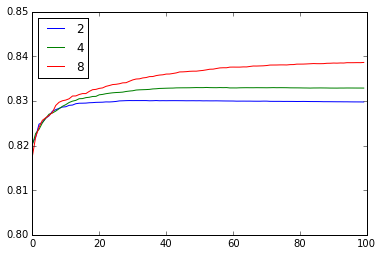

In [37]:
plt.plot(get_aucs(d1.cls_c, d1.dc, n=1), label="2")
plt.plot(get_aucs(d2.cls_c, d2.dc, n=1), label="4")
plt.plot(get_aucs(d3.cls_c, d3.dc, n=1), label="8")
plt.ylim(0.8, 0.85)
plt.legend(loc="best")

In [38]:
def draw_rocs(a, ar, rocs, labels=None):
    xs = numpy.linspace(0, 1, 501)
    rfirst = rocs[0]
    if not labels:
        labels = [str(i) for i in range(len(rocs))]
    for ir, r in enumerate(rocs):
        lw = 1
        if ir<2:
            lw = 2
        a.plot(r[1], r[0], label=labels[ir], lw=lw)
        ar.plot(xs, numpy.interp(xs, r[1], r[0])/numpy.interp(xs, rfirst[1], rfirst[0]), lw=lw)

In [39]:
rs = [d.rocs() for d in [d1, d1_lpt, d1_hpt]]
rl = [r[1] for r in rs]
rc = [r[0] for r in rs]

In [40]:
rl.insert(0, roc_csv_ivf_l)
rl.insert(1, roc_csv_l)

rc.insert(0, roc_csv_ivf_c)
rc.insert(1, roc_csv_c)

In [41]:
labels = ["CSV IVF", "CSV", "comb", "comb lpt", "comb hpt"]

In [42]:
csv_wp = 0.679
b_eff_csv = sum(dt[dt["cl"]==2]["csv"] > csv_wp)/float(len(dt[dt["cl"]==2]))
l_eff_csv = sum(dt[dt["cl"]==0]["csv"] > csv_wp)/float(len(dt[dt["cl"]==0]))
c_eff_csv = sum(dt[dt["cl"]==1]["csv"] > csv_wp)/float(len(dt[dt["cl"]==1]))

In [43]:
csv_ivf_wp = 0.814 
b_eff_csv_ivf = sum(dt[dt["cl"]==2]["csv_ivf"] > csv_ivf_wp)/float(len(dt[dt["cl"]==2]))
l_eff_csv_ivf = sum(dt[dt["cl"]==0]["csv_ivf"] > csv_ivf_wp)/float(len(dt[dt["cl"]==0]))
c_eff_csv_ivf = sum(dt[dt["cl"]==1]["csv_ivf"] > csv_ivf_wp)/float(len(dt[dt["cl"]==1]))

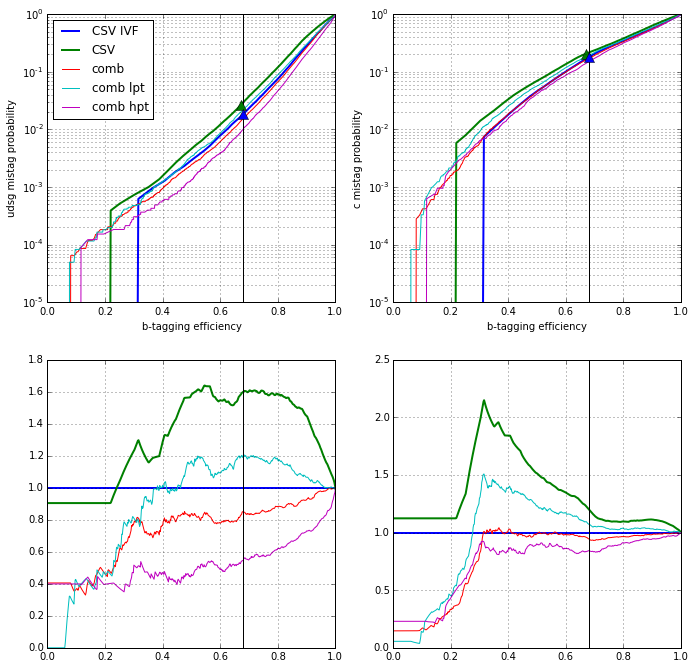

In [44]:
plt.figure(figsize=(8,8))
a1 = plt.axes([0.0, 0.6, 0.5, 0.5])
a2 = plt.axes([0.6, 0.6, 0.5, 0.5], sharex=a1)

a1.set_yscale("log")
a2.set_yscale("log")
a1.set_ylabel("udsg mistag probability")
a2.set_ylabel("c mistag probability")
a1.set_xlabel("b-tagging efficiency")
a2.set_xlabel("b-tagging efficiency")
#a1.set_yticks(numpy.linspace(0.5, 1.0, 11))
#a1.set_yticklabels(numpy.linspace(0.5, 1.0, 11))

a1r = plt.axes([0.0, 0.0, 0.5, 0.5], sharex=a1)
a2r = plt.axes([0.6, 0.0, 0.5, 0.5], sharex=a2)


draw_rocs(a1, a1r, rl, labels)
draw_rocs(a2, a2r, rc)

#a1.axhline(0.1, color="black")
#a1.axhline(0.02, color="black")

a1.axvline(0.68, color="black")
a1r.axvline(0.68, color="black")

a2.axvline(0.68, color="black")
a2r.axvline(0.68, color="black")

a1.set_xlim(0.0, 1.0)
#a2.set_xlim(0.6, 1.0)

a1.grid(which="both")
a2.grid(which="both")

a1r.grid()
a2r.grid(which="both")

a1.plot([b_eff_csv],[l_eff_csv], marker="^", markersize=10, color="green")
a1.plot([b_eff_csv_ivf],[l_eff_csv_ivf], marker="^", markersize=10, color="blue")

a2.plot([b_eff_csv],[c_eff_csv], marker="^", markersize=10, color="green")
a2.plot([b_eff_csv_ivf],[c_eff_csv_ivf], marker="^", markersize=10, color="blue")

#a1.set_ylim(0.001, 1.0)
#a2.set_ylim(0.1, 1.0)

#a1r.set_ylim(0.75, 1.1)
#a2r.set_ylim(0.8, 1.2)

#a2.set_yticks(numpy.linspace(0.1, 1.1, 11))
#a2.set_yticklabels(numpy.linspace(0.1, 1.1, 11))
a1.legend(loc="best")

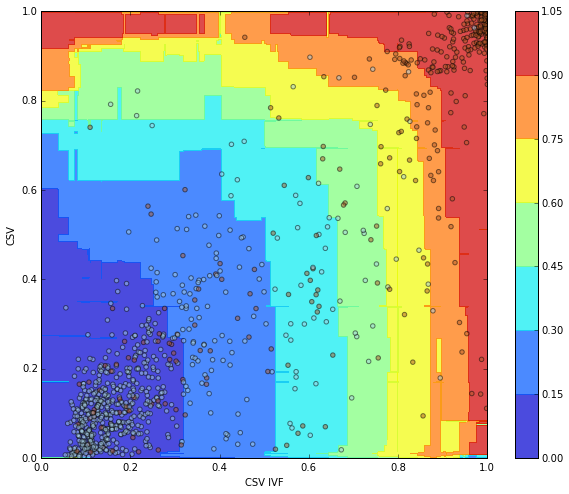

In [45]:
xx, yy = numpy.meshgrid(numpy.linspace(0, 1, 1000), numpy.linspace(0, 1, 1000))
N = len(xx.ravel())
a = numpy.c_[xx.ravel(), yy.ravel()]
b = numpy.zeros((N, 2))
b[:,0:2] = a[:, :]
Z = d1.cls_l.predict_proba(b)
z = Z[:, 1]
z = z.reshape(xx.shape)
plt.figure(figsize=(10,8))
plt.contourf(xx, yy, z, alpha=0.7)
plt.colorbar()
Nplot = 1000
plt.scatter(
    d1.dl.X_test[:Nplot]["csv_ivf"], d1.dl.X_test[:Nplot]["csv"], c=numpy.array(d1.dl.y_test)[:Nplot],
    marker="o", alpha=0.5, cmap=plt.cm.Paired
)
# plt.title("sig={0} bkg={1}".format(
#         sum(d1.dl.y_test[sel]["cl"]==1),
#         sum(d1.dl.y_test[sel]["cl"]==0),
# ))
plt.xlim(0, 1)
plt.ylim(0,1)
plt.xlabel("CSV IVF")
plt.ylabel("CSV")

In [46]:
def plot_pt(pt, eta):
    xx, yy = numpy.meshgrid(numpy.linspace(0, 1, 1000), numpy.linspace(0, 1, 1000))
    N = len(xx.ravel())
    a = numpy.c_[xx.ravel(), yy.ravel()]
    b = numpy.zeros((N, 4))
    b[:,0:2] = a[:, :]
    b[:, 2] = pt
    b[:, 3] = eta
    Z = d2.cls_l.predict_proba(b)
    z = Z[:, 1]
    z = z.reshape(xx.shape)
    plt.figure(figsize=(10,8))
    plt.contourf(xx, yy, z, alpha=0.7)
    plt.colorbar()
    Nplot = 10000
    sel = (d2.dl.X_test["pt"]>pt-10) & (d2.dl.X_test["pt"]<pt+10) & (d2.dl.X_test["abs_eta"]>eta-0.1) & (d2.dl.X_test["abs_eta"]<eta+0.1)
    plt.scatter(
        d2.dl.X_test[sel][:Nplot]["csv_ivf"], d2.dl.X_test[sel][:Nplot]["csv"], c=numpy.array(d2.dl.y_test[sel])[:Nplot],
        marker="o", alpha=0.5, cmap=plt.cm.Paired
    )
    plt.title("sig={0} bkg={1}".format(
            sum(d2.dl.y_test[sel]["cl"]==1),
            sum(d2.dl.y_test[sel]["cl"]==0),
    ))
    plt.xlim(0, 1)
    plt.ylim(0,1)
    plt.xlabel("CSV IVF")
    plt.ylabel("CSV")

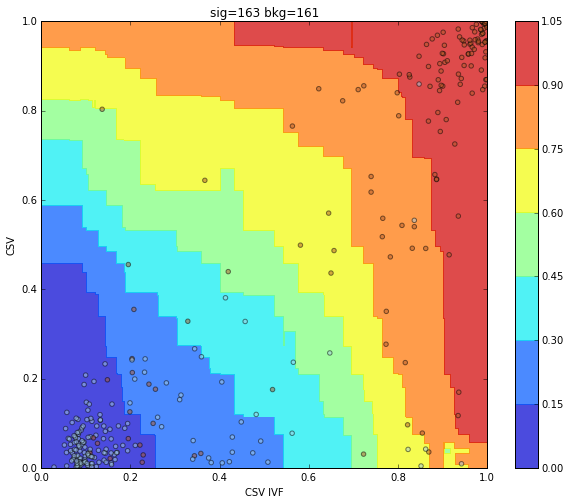

In [47]:
i = interact(plot_pt, pt=(0, 300), eta=(0, 2.5))

In [48]:
csv_ivf_wp = 0.814 
b_eff_csv_ivf = sum(train_dt[train_dt["cl"]==2]["csv_ivf"]>csv_ivf_wp)/float(len(train_dt[train_dt["cl"]==2]))
nonb_eff_csv_ivf = sum(train_dt[train_dt["cl"]!=2]["csv_ivf"]>csv_ivf_wp)/float(len(train_dt[train_dt["cl"]!=2]))

NameError: name 'train_dt' is not defined

In [ ]:
b_eff_csv, nonb_eff_csv

In [ ]:
b_eff_csv_ivf, nonb_eff_csv_ivf

In [ ]:
plt.figure(figsize=(8,8))
plt.plot(tpr_csv, fpr_csv, label="CSV", lw=2, color="green")
#plt.plot(tpr_csv_train, fpr_csv_train, label="CSV (training)", lw=1, color="green", ls="--")

plt.plot(tpr_csv_ivf, fpr_csv_ivf, marker=".", label="CSV IVF", lw=2, markersize=0, color="red")
plt.plot([b_eff_csv], [nonb_eff_csv], marker="^", lw=0, markersize=10, color="green", label="CSV M")
plt.plot([b_eff_csv_ivf], [nonb_eff_csv_ivf], marker="^", lw=0, markersize=10, color="red", label="CSV IVF M")

#plt.plot(tpr_knn, fpr_knn, label="combined knn", markersize=0, color="blue")
#plt.plot(tpr_svc, fpr_svc, label="combined svm", markersize=0, color="orange")
#plt.plot(tpr_gnb, fpr_gnb, label="combined LH", markersize=0, color="purple")
plt.plot(tpr_gradb, fpr_gradb, label="combined gradbdt", markersize=0, color="orange", lw=2)

plt.xlabel("b-tagging efficiency")
plt.ylabel("mis-tagging probability")
#plt.yscale("log")
plt.ylim(0.0, 0.2)
plt.xlim(0.4, 0.8)
plt.yticks(numpy.linspace(0.0, 0.2, 21))
plt.xticks(numpy.linspace(0.4, 1.0, 11))
plt.grid()
plt.legend(loc="best", numpoints=1)

In [ ]:
arr = numpy.zeros((21, 7), dtype=float)
b = dt[dt["cl"] == 2]
l = dt[dt["cl"] != 2]

for i, x in enumerate(numpy.linspace(0, 1, 21)):
    e1b = sum(b["comb_csv"] > x) / float(len(b))
    e2b = sum(b["csv"] > x) / float(len(b))
    e3b = sum(b["csv_ivf"] > x) / float(len(b))
    e1l = sum(l["comb_csv"] > x) / float(len(l))
    e2l = sum(l["csv"] > x) / float(len(l))
    e3l = sum(l["csv_ivf"] > x) / float(len(l))
    arr[i, 0] = x
    arr[i, 1] = e1b
    arr[i, 2] = e2b
    arr[i, 3] = e3b
    arr[i, 4] = e1l
    arr[i, 5] = e2l
    arr[i, 6] = e3l
    print i, x

In [ ]:
plt.plot(arr[:, 1], arr[:, 4])
plt.plot(arr[:, 3], arr[:, 6])
plt.ylim(0.0, 0.2)
plt.xlim(0.4, 0.8)
plt.yticks(numpy.linspace(0.0, 0.2, 21))
plt.xticks(numpy.linspace(0.4, 1.0, 11))
plt.grid()